# <font color="SaddleBrown">🎯 Домашнее задание к семинару 06 (HW06)  </font>
<font color="SaddleBrown"> **Деревья решений и ансамбли. Честный ML-эксперимент**</font>

В этом ноутбуке был выполнен **честный ML-эксперимент** по сравнению деревьев решений и ансамблевых моделей в едином протоколе.

В ходе работы:

* был использован синтетический табличный датасет **`S06-hw-dataset-02.csv`**, представляющий задачу бинарной классификации с шумом и нелинейными взаимодействиями признаков, и зафиксировано разбиение на **train / test**;;
* была построена **baseline-модель** (`DummyClassifier`) для задания нижней границы качества;
* были обучены и сравнены модели недели 6:

  * `Decision Tree`,
  * `Random Forest`,
  * `(Hist) Gradient Boosting`,
  * `Stacking` (опционально);
* подбор гиперпараметров выполнялся **только на train-части** с использованием кросс-валидации;
* финальная оценка качества моделей проводилась на **отложенной test-выборке**;
* модели сравнивались по единым метрикам качества: **accuracy, F1-score и ROC-AUC**;
* были построены диагностические визуализации (ROC-кривые, confusion matrix, анализ важности признаков);
* артефакты эксперимента (метрики, параметры моделей и обученные модели) были сохранены в папку `artifacts/`.

Целью эксперимента было не максимизировать значение метрик, а продемонстрировать **инженерно корректный и воспроизводимый подход** к сравнению моделей и фиксации результатов.

# Импорты и общие настройки

В этом блоке мы подключаем все необходимые библиотеки и задаём базовые настройки ML-эксперимента.

Используются:

* **numpy, pandas** — базовые библиотеки для работы с числовыми и табличными данными;
* **matplotlib** — для визуализации (ROC-кривые, графики важности признаков);
* из **sklearn**:

  * `datasets` — для загрузки встроенного датасета (breast cancer);
  * `model_selection` — разбиение данных на train/test, стратифицированная кросс-валидация и подбор гиперпараметров через `GridSearchCV`;
  * `metrics` — метрики качества классификации (accuracy, F1, ROC-AUC), confusion matrix и инструменты для построения ROC-кривых;
  * `dummy` — базовый классификатор для sanity check;
  * `pipeline` и `preprocessing` — построение пайплайнов и масштабирование признаков;
  * модели: `LogisticRegression`, `DecisionTreeClassifier`, ансамбли (`RandomForestClassifier`, `HistGradientBoostingClassifier`, `StackingClassifier`);
  * `inspection` — permutation importance для анализа важности признаков;
* **joblib** — для сохранения обученных моделей и артефактов эксперимента;
* **pathlib** и **json** — для удобной работы с файлами и сохранения результатов.

Дополнительно:

* фиксируется `RANDOM_STATE`, чтобы все случайные компоненты эксперимента были воспроизводимыми;
* создаётся папка `artifacts/`, в которую будут сохраняться модели, метрики и другие результаты эксперимента.

In [6]:
# Импорты и базовые настройки эксперимента.

# - Фиксируем RANDOM_STATE, чтобы случайные компоненты были воспроизводимыми.
# - Создаём папку artifacts/ – туда будем складывать результаты и модель.

from __future__ import annotations

import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    confusion_matrix, RocCurveDisplay
)

from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, StackingClassifier
from sklearn.inspection import permutation_importance

import joblib

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

ARTIFACTS_DIR = Path("artifacts")
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

print("Artifacts dir:", ARTIFACTS_DIR.resolve())

Artifacts dir: /content/artifacts


# Вспомогательные функции

In [10]:
# Вспомогательные функции для эксперимента:
# - compute_metrics: считает метрики (accuracy, F1, ROC-AUC при наличии вероятностей)
# - evaluate_on_test: единообразная оценка модели на тесте
# - save_json: аккуратное сохранение артефактов
# - plot_confusion / plot_roc: быстрая диагностика качества

def compute_metrics(y_true, y_pred, y_proba=None) -> dict:
    m = {
        "accuracy": float(accuracy_score(y_true, y_pred)),
        "f1": float(f1_score(y_true, y_pred)),
    }
    if y_proba is not None:
        try:
            m["roc_auc"] = float(roc_auc_score(y_true, y_proba))
        except Exception:
            m["roc_auc"] = None
    else:
        m["roc_auc"] = None
    return m

def evaluate_on_test(model, X_test, y_test, label: str) -> dict:
    pred = model.predict(X_test)
    proba = None
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X_test)[:, 1]
    metrics = compute_metrics(y_test, pred, proba)
    metrics["model"] = label
    return metrics

def save_json(obj: dict, path: Path):
    path.parent.mkdir(parents=True, exist_ok=True)
    with path.open("w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)

def plot_confusion(y_true, y_pred, title: str):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    plt.imshow(cm)
    plt.title(title)
    plt.xlabel("pred")
    plt.ylabel("true")
    plt.xticks([0, 1])
    plt.yticks([0, 1])
    for (i, j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha="center", va="center")
    plt.show()

def plot_roc(model, X_test, y_test, title: str):
    if not hasattr(model, "predict_proba"):
        print("ROC: модель не поддерживает predict_proba")
        return
    RocCurveDisplay.from_estimator(model, X_test, y_test)
    plt.title(title)
    plt.show()

# 1. Загрузка датасета и первичный анализ

Для домашнего задания использован синтетический датасет **S06-hw-dataset-02.csv**.

Датасет представляет собой задачу бинарной классификации: требуется предсказывать целевую переменную `target` (0/1) на основе табличных признаков.
Датасет содержит только числовые признаки с непрерывными значениями, целый признак `id`, что делает его удобным для работы с деревьями решений и ансамблевыми методами.

На этом шаге:

* загружаем данные в `pandas.DataFrame` с помощью `pd.read_csv`;
* выводим первые строки таблицы (`head()`), чтобы получить первичное представление о структуре данных;
* анализируем типы столбцов, наличие пропусков и базовую статистику числовых признаков (`info()`, `describe()`);
* смотрим распределение целевого класса, оцениваем дисбаланс;
* формируем матрицу признаков `X` (все столбцы, кроме `target` и `id`) и таргет `y` (`target`).


In [25]:
# Загружаем датасет
url = 'https://raw.githubusercontent.com/TatjanaYMIREA/aie-group-2/main/homeworks/HW06/data/S06-hw-dataset-02.csv'
df = pd.read_csv(url)

# Размер датасета
print("Dataset shape:", df.shape)

# Просмотр первых строк
print("\nFirst 5 rows:")
print(df.head())

# Общая информация о датасете
print("\nDataset info:")
df.info()

# Базовые статистики
print("\nDescriptive statistics:")
print(df.describe())

# Проверка пропусков
print("\nMissing values per column:")
print(df.isna().sum())

# Распределение целевой переменной
target_col = "target"
target_distribution = df[target_col].value_counts(normalize=True)

print("\nTarget distribution (fractions):")
print(target_distribution)

# Формирование признаков и таргета
drop_cols = [target_col]
if "id" in df.columns:
    drop_cols.append("id")

X = df.drop(columns=drop_cols)
y = df[target_col]
feature_names = X.columns.tolist()

print("\nX shape:", X.shape)
print("y shape:", y.shape)


Dataset shape: (18000, 39)

First 5 rows:
   id       f01       f02       f03        f04       f05       f06       f07  \
0   1 -0.149235 -2.826966 -0.522901  -4.198449  1.364943  0.815043 -1.195518   
1   2 -1.966180 -4.877542  0.268367  -9.607791  0.097149  1.347185 -3.872575   
2   3 -0.555964 -0.999920  0.209673 -14.119498 -1.808950 -0.006222 -4.651108   
3   4 -2.049199 -5.600713 -1.664677  -6.263893 -5.224455  0.848351  1.407210   
4   5 -0.220556  4.889479 -2.235840   6.450046  0.774389 -2.382625  2.584816   

        f08       f09  ...       f29       f30       f31       f32       f33  \
0 -1.932232  2.396353  ... -0.159323  0.448015  0.572745  0.149916  0.878392   
1 -0.395117  1.710068  ... -0.389212  1.383794  0.169876  0.043969 -0.963545   
2  0.911944 -0.289037  ... -1.383970  3.044321 -0.182864  1.425649 -8.418598   
3 -0.542080  0.119102  ... -2.713080  2.762637 -0.520796 -0.142455  1.668338   
4  4.211856 -0.317889  ... -1.302872  2.478862  1.528610  1.098131  3.547087 

### <font color="blue">📝 Наблюдения</font>
* В датасете 18 000 объектов и 37 признаков (без учёта таргета) — достаточно для базового моделирования.
* Пропусков в данных нет, что упрощает дальнейшую обработку и обучение моделей.
* Все числовые признаки находятся в разумных диапазонах, явно некорректных значений не обнаружено.
* Распределение целевого признака `target` умеренно несбалансировано: около 26% объектов имеют значение 1 и 74% — значение 0.
* Такой дисбаланс заметен, но не экстремален; модели могут обучаться без строгих методов балансировки, однако при оценке качества важно использовать метрики, чувствительные к меньшему классу, такие как F1-score, precision/recall и ROC-AUC.

# 2. Train/Test-сплит и воспроизводимость

Данные были разделены на `train` и `test` следующим образом:

* 20% объектов были выделены в `test`-набор для финальной проверки моделей, 80% остались для обучения и валидации.
* При разделении использовалась стратификация по целевой переменной (`stratify=y`), чтобы сохранить соотношение классов в каждом наборе.
* Для воспроизводимости результатов фиксировался `random_state=42`.

Фиксированный `seed` позволяет получать одинаковые разбиения при повторных запусках, что важно для воспроизводимости эксперимента и сравнения моделей. Стратификация обеспечивает сохранение долей классов в `train` и `test`, предотвращая случайное искажение дисбаланса и обеспечивая корректную оценку качества классификации.

In [12]:
# разбиение данных на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=RANDOM_STATE,
    stratify=y
)

print(X_train.shape, X_test.shape)

# вывод точного соотношения классов в разбиении
print("Train target distribution:")
print(y_train.value_counts(normalize=True))
print("Test target distribution:")
print(y_test.value_counts(normalize=True))

(13500, 37) (4500, 37)
Train target distribution:
target
0    0.737407
1    0.262593
Name: proportion, dtype: float64
Test target distribution:
target
0    0.737333
1    0.262667
Name: proportion, dtype: float64


### <font color="blue">📝 Наблюдения</font>
* Размеры выборок соответствуют заданному сплиту: **`train` — 13 500 объектов**, **`test` — 4 500 объектов**, при одинаковом числе признаков (37).
* Распределение целевого признака практически совпадает в обеих выборках: около **73.7% объектов класса 0** и **26.3% объектов класса 1** как в `train`, так и в `test`. Это подтверждает корректное использование `stratify=y` при разбиении данных.
* Таким образом, разбиение является воспроизводимым и сохраняет пропорции целевой переменной, что позволяет корректно сравнивать модели и оценивать их качество на отложенной `test`-выборке.

# 3. Baseline’ы

Прежде чем переходить к более сложным моделям, была построена **базовая (baseline) модель**, позволяющая понять минимальный уровень качества, который можно получить без использования информации из признаков.

В качестве такого бейзлайна использовался
`DummyClassifier(strategy="most_frequent")`, который всегда предсказывает **наиболее частый класс**, наблюдаемый в обучающей выборке.  
Такая модель практически не обучается в привычном смысле и служит ориентиром: **любая осмысленная модель должна превосходить её по качеству**.

На этом этапе:

1. Бейзлайн был обучен на `X_train, y_train`
2. Качество модели было оценено на отложенной **test-выборке** с использованием единого набора метрик


Для оценки качества использовались следующие метрики:

* **accuracy** — доля правильных предсказаний;
* **F1-score** — баланс между precision и recall, особенно важный при несбалансированных классах;
* **ROC-AUC** — площадь под ROC-кривой, характеризующая способность модели ранжировать объекты по вероятности принадлежности к положительному классу.

Поскольку целевой признак в датасете умеренно несбалансирован, интерпретация результатов не ограничивалась одной accuracy; ключевую роль при сравнении моделей играли F1-score и ROC-AUC.


In [13]:
# Baseline'ы и подготовка контейнеров для результатов.

# - results: список словарей с метриками на тесте
# - best_models: сюда складываем обученные лучшие модели (чтобы потом их диагностировать/сохранить)
# - search_summaries: сюда складываем лучшие параметры подбора и CV-оценку

# CV = кросс-валидация на train: нужна для подбора гиперпараметров без доступа к тесту.
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

results = []
best_models = {}  # label -> fitted best estimator
search_summaries = {}  # label -> краткая инфа о подборе

# 2.1 Dummy baseline (без подбора)

# Dummy baseline: помогает понять, что модель вообще умеет что-то лучше «угадайки».
dummy = DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE)
dummy.fit(X_train, y_train)
results.append(evaluate_on_test(dummy, X_test, y_test, "Dummy(most_frequent)"))
best_models["Dummy(most_frequent)"] = dummy

# 2.2 LogisticRegression baseline (с минимальным подбором)

# Логрегрессия почти всегда требует масштабирования признаков, поэтому используем Pipeline со StandardScaler.
lr = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(max_iter=4000, random_state=RANDOM_STATE))
])


# Подбираем C (обратная сила регуляризации): меньше C -> сильнее регуляризация -> проще модель.
lr_grid = {
    "lr__C": [0.1, 1.0, 10.0],
    "lr__penalty": ["l2"],
    "lr__solver": ["lbfgs"],
}


# GridSearchCV перебирает сетку параметров и оценивает качество по CV. scoring=roc_auc – метрика для бинарной классификации по вероятностям.
lr_search = GridSearchCV(
    lr, lr_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    refit=True,
    return_train_score=True
)
lr_search.fit(X_train, y_train)

best_lr = lr_search.best_estimator_
best_models["LogReg(scaled)"] = best_lr

search_summaries["LogReg(scaled)"] = {
    "best_params": lr_search.best_params_,
    "best_cv_roc_auc": float(lr_search.best_score_),
}

results.append(evaluate_on_test(best_lr, X_test, y_test, "LogReg(scaled)"))

search_summaries["LogReg(scaled)"]

{'best_params': {'lr__C': 10.0, 'lr__penalty': 'l2', 'lr__solver': 'lbfgs'},
 'best_cv_roc_auc': 0.8031650183229327}

### <font color="blue">📝 Наблюдения</font>
* **DummyClassifier (`strategy="most_frequent"`)** всегда предсказывает наиболее частый класс, наблюдаемый в обучающей выборке (класс 0). Такая модель полностью игнорирует признаки и не способна различать классы.

* Ожидаемо, качество Dummy-baseline ограничивается долей доминирующего класса: модель демонстрирует относительно высокую accuracy за счёт предсказания класса 0, но при этом не выявляет объекты положительного класса.
* ROC-AUC близок к 0.5, что указывает на отсутствие способности к ранжированию объектов. Данный бейзлайн служит минимальной точкой отсчёта для дальнейшего сравнения моделей.

* **Логистическая регрессия (с масштабированием признаков)** уже использует информацию из признаков и позволяет оценить, насколько линейная модель способна решать данную задачу.  
* В ходе кросс-валидационного подбора гиперпараметров была выбрана конфигурация с `C = 10.0` и `l2`-регуляризацией, что соответствует относительно слабой регуляризации.

* Лучшее значение ROC-AUC на кросс-валидации составило около **0.80**, что существенно превышает уровень случайного угадывания и говорит о наличии устойчивого сигнала в данных.
* По сравнению с Dummy-baseline логистическая регрессия значительно лучше различает классы и служит разумным обучаемым бейзлайном, относительно которого далее будут оцениваться деревья решений и ансамблевые модели.



# 4. Кандидаты недели 6: дерево, лес, бустинг

### Сравнение моделей и протокол эксперимента

В этом разделе сравниваются три семейства моделей недели 6, которые хорошо подходят для табличных данных и бинарной классификации:

* **Decision Tree** — простая нелинейная модель, легко интерпретируемая и быстро обучающаяся.
  При отсутствии ограничений глубины дерево склонно к переобучению, поэтому в подборе гиперпараметров явно контролируется сложность модели с помощью `max_depth`, `min_samples_leaf` и `ccp_alpha` (cost-complexity pruning).

* **Random Forest** — ансамбль деревьев, обученных на разных подвыборках данных и признаков (bagging).
  За счёт усреднения предсказаний лес обычно менее чувствителен к шуму и переобучению, чем одно дерево.
  В эксперименте контролируется сложность базовых деревьев (`max_depth`, `min_samples_leaf`), а также разнообразие ансамбля через параметр `max_features`.

* **HistGradientBoosting** — градиентный бустинг по гистограммам, эффективный и масштабируемый алгоритм, который часто показывает высокое качество на табличных признаках.
  Качество и устойчивость модели регулируются шагом обучения (`learning_rate`) и сложностью базовых деревьев (`max_depth`, `max_leaf_nodes`).
  Включён `early_stopping`, что дополнительно защищает модель от переобучения за счёт внутренней валидации на обучающей выборке.

---

### Протокол подбора гиперпараметров и оценки

Для всех моделей используется единый и воспроизводимый протокол:

* **Подбор гиперпараметров** выполняется только на обучающей выборке (`X_train`, `y_train`) с помощью `GridSearchCV` и стратифицированной кросс-валидации (`StratifiedKFold`), что сохраняет пропорции классов на каждом фолде.
* В качестве метрики подбора используется **ROC-AUC**, так как задача является бинарной классификацией, а все рассматриваемые модели возвращают вероятности классов. Эта метрика отражает способность модели корректно ранжировать объекты и менее чувствительна к умеренному дисбалансу классов, чем accuracy.
* **Тестовая выборка** (`X_test`, `y_test`) используется строго **один раз** — для финальной оценки уже подобранных моделей. Это обеспечивает честное сравнение алгоритмов и исключает утечку информации из test в процесс обучения или подбора параметров.



## GridSearchCV

In [14]:
# Единая функция для подбора гиперпараметров через GridSearchCV.

# Она:
# - обучает GridSearchCV на X_train/y_train
# - кладёт лучшую модель и summary в словари
# - добавляет финальную оценку на тесте в results

def run_search(label: str, estimator, param_grid: dict):
    search = GridSearchCV(
        estimator,
        param_grid,
        scoring="roc_auc",
        cv=cv,
        n_jobs=-1,
        refit=True,
        return_train_score=True
    )
    search.fit(X_train, y_train)

    best = search.best_estimator_
    best_models[label] = best
    search_summaries[label] = {
        "best_params": search.best_params_,
        "best_cv_roc_auc": float(search.best_score_),
    }
    results.append(evaluate_on_test(best, X_test, y_test, label))
    return search

## Decision Tree

In [15]:
# Decision Tree: одна модель дерева решений.

# Что обычно делает дерево “сложнее” и склоннее к переобучению:
# - большой max_depth
# - маленький min_samples_leaf
# ccp_alpha – параметр cost-complexity pruning (штраф за сложность).

# 3.1 Decision Tree
dt = DecisionTreeClassifier(random_state=RANDOM_STATE)

dt_grid = {
    "max_depth": [None, 3, 5, 8],
    "min_samples_leaf": [1, 5, 10, 20],
    "ccp_alpha": [0.0, 0.001, 0.005, 0.01],
}

dt_search = run_search("DecisionTree", dt, dt_grid)
search_summaries["DecisionTree"]

{'best_params': {'ccp_alpha': 0.0, 'max_depth': 8, 'min_samples_leaf': 20},
 'best_cv_roc_auc': 0.8266101547230521}

### <font color="blue">📝 Наблюдения</font>
**Decision Tree** с подобранными гиперпараметрами показала устойчивое качество на кросс-валидации:

* **Лучшие параметры**: `max_depth=8`, `min_samples_leaf=20`, `ccp_alpha=0.0`.
  Это означает, что дерево ограничено по глубине и минимальному числу объектов в листьях, что помогает контролировать переобучение. `ccp_alpha=0.0` говорит, что дополнительное штрафование за сложность не применялось, так как ограничения глубины и размера листа уже достаточно.

* **ROC-AUC на CV**: ≈ 0.827.
  Это существенно выше случайного угадывания (0.5) и показывает, что дерево способно корректно ранжировать объекты по вероятности положительного класса.

Таким образом, Decision Tree значительно лучше, чем DummyClassifier и даже лучше обучаемого линейного бейзлайна (LogisticRegression), демонстрируя способность улавливать нелинейные зависимости в данных.

Ограничения по глубине и размерам листьев позволили найти баланс между **сильной моделью** и **контролем переобучения**, что подтверждает корректный подход к подбору параметров на `train` через `CV`.

## Random Forest

In [17]:
# Random Forest: ансамбль деревьев (bagging).

# Идеи:
# - много деревьев (n_estimators) снижает дисперсию
# - max_features добавляет разнообразие деревьев (важно для ансамблей)
# - ограничения глубины/листа помогают контролировать переобучение

# 3.2 Random Forest
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    oob_score=False
)
# n_estimators=200 вместо 600 -> очень долго обучается!!!

# rf_grid = {
#     "max_depth": [None, 6, 10],
#     "min_samples_leaf": [1, 5, 10],
#     "max_features": ["sqrt", 0.5],
# }

# сокращено из-за значительного времени обучения
rf_grid = {
    "max_depth": [6, 10],
    "min_samples_leaf": [5, 10],
    "max_features": ["sqrt"]
}

rf_search = run_search("RandomForest", rf, rf_grid)
search_summaries["RandomForest"]

{'best_params': {'max_depth': 10,
  'max_features': 'sqrt',
  'min_samples_leaf': 5},
 'best_cv_roc_auc': 0.916672133203081}

### <font color="blue">📝 Наблюдения</font>
**RandomForestClassifier** – ансамбль из множества деревьев, который снижает дисперсию и обычно более устойчив к переобучению, чем одно дерево.

* **Подобранные гиперпараметры:**

  * `max_depth=10` – деревья умеренной глубины, что помогает контролировать переобучение.
  * `min_samples_leaf=5` – каждый лист содержит как минимум 5 объектов, что тоже стабилизирует модель.
  * `max_features='sqrt'` – на каждом разбиении выбирается только часть признаков (корень из общего числа), что повышает разнообразие деревьев в ансамбле.

* **CV-оценка (best_cv_roc_auc = 0.917)**

  * Показатель ROC-AUC на кросс-валидации показывает, что модель хорошо различает классы на unseen train-данных, ранжируя объекты по вероятности принадлежности к классу 1.
  * Значение близко к 0.92 говорит о высокой способности классификатора отличать положительные и отрицательные объекты.

* **Вывод:**

  * Модель успешно использует ансамбль деревьев, избегает сильного переобучения за счёт ограничений глубины и минимального числа объектов в листьях.
  * ROC-AUC существенно выше, чем у бейзлайнов (Dummy ~0.5, LogisticRegression ~0.80), что подтверждает ценность ансамбля.

## HistGradientBoosting

In [18]:
# HistGradientBoosting: градиентный бустинг по гистограммам (быстро и часто качественно).

# Ключевые “ручки”:
# - learning_rate: шаг обучения (меньше -> аккуратнее, часто нужно больше итераций)
# - max_depth / max_leaf_nodes: сложность базовых деревьев
# early_stopping=True включает остановку по внутренней валидации на train.

# 3.3 HistGradientBoosting (быстрый градиентный бустинг в sklearn)
hgb = HistGradientBoostingClassifier(
    random_state=RANDOM_STATE,
    early_stopping=True
)

# сокращено из-за значительного времени обучения
# hgb_grid = {
#     "learning_rate": [0.03, 0.05, 0.1],
#     "max_depth": [2, 3, None],
#     "max_leaf_nodes": [15, 31, 63],
# }

hgb_grid = {
    "learning_rate": [0.05, 0.1],      # убрать 0.03
    "max_depth": [2, 3],                # убрать None
    "max_leaf_nodes": [31, 63]          # убрать 15
}
hgb_search = run_search("HistGradientBoosting", hgb, hgb_grid)
search_summaries["HistGradientBoosting"]

{'best_params': {'learning_rate': 0.1, 'max_depth': 3, 'max_leaf_nodes': 31},
 'best_cv_roc_auc': 0.8975895053835348}

### <font color="blue">📝 Наблюдения</font>
**HistGradientBoostingClassifier** – градиентный бустинг по гистограммам, который строит последовательные деревья, исправляя ошибки предыдущих, что часто даёт высокое качество на табличных данных.

* **Подобранные гиперпараметры:**

  * `learning_rate=0.1` – относительно быстрый шаг обучения; позволяет модели быстрее адаптироваться к ошибкам, при этом контролируя переобучение.
  * `max_depth=3` – небольшая глубина деревьев, что стабилизирует бустинг и предотвращает переобучение.
  * `max_leaf_nodes=31` – ограничение числа листьев дополнительно контролирует сложность отдельных деревьев.

* **CV-оценка (best_cv_roc_auc ≈ 0.898)**

  * Значение ROC-AUC почти 0.90 на кросс-валидации показывает, что модель хорошо ранжирует объекты по вероятности принадлежности к положительному классу.
  * Модель превосходит LogisticRegression (~0.80) и заметно выше Random Dummy (~0.5).

* **Вывод:**

  * Градиентный бустинг эффективно использует слабые деревья для повышения качества.
  * Ограничения глубины и числа листьев помогают сохранить баланс между качеством и стабильностью модели.
  * Эта модель демонстрирует сильную способность к классификации на твоём синтетическом датасете, уступая немного Random Forest по CV ROC-AUC, но оставаясь высокой по сравнению с базовыми моделями.

# 5. Stacking

В качестве дополнительного шага используется **StackingClassifier** — ансамбль, который комбинирует предсказания нескольких уже обученных моделей с помощью метамодели.

В данном эксперименте в стекинг входят:

* логистическая регрессия с масштабированием признаков (как сильный линейный бейзлайн);
* Random Forest;
* HistGradientBoosting.

Предсказания этих моделей используются в качестве входных признаков для **метамодели**, роль которой выполняет логистическая регрессия. Такой выбор позволяет получить линейную и устойчивую комбинацию выходов базовых моделей без существенного увеличения сложности.

Ключевые моменты протокола:

* `StackingClassifier` **внутри использует кросс-валидацию** (`cv=5`) для формирования обучающей выборки метамодели, что предотвращает утечку информации и делает процедуру корректной с точки зрения машинного обучения.
* Подбор гиперпараметров для стекинга намеренно не выполняется: стекинг используется как **честная финальная комбинация** уже подобранных моделей, а не как ещё один объект сложного тюнинга.
* Обучение стекинга проводится только на `X_train, y_train`, а тестовая выборка используется один раз — для финальной оценки качества, наравне с остальными моделями.

Таким образом, стекинг здесь служит иллюстрацией того, как можно аккуратно объединять разные подходы в рамках единого протокола, не нарушая принципов воспроизводимости и честного сравнения моделей.

In [19]:
# Stacking (опционально): ансамбль из нескольких уже обученных моделей + метамодель.

# - estimators: базовые модели (их предсказания идут на вход метамодели)
# - final_estimator: метамодель (здесь логистическая регрессия)
# - cv=5: CV внутри стекинга, чтобы метамодель училась без утечки

estimators = [
    ("lr", best_models["LogReg(scaled)"]),
    ("rf", best_models["RandomForest"]),
    ("hgb", best_models["HistGradientBoosting"]),
]

stack = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=4000, random_state=RANDOM_STATE),
    cv=5,
    n_jobs=-1,
    passthrough=False
)

# Стекинг обычно имеет мало “ручек”, поэтому без GridSearch – просто честная оценка
stack.fit(X_train, y_train)
best_models["Stacking"] = stack
results.append(evaluate_on_test(stack, X_test, y_test, "Stacking"))

{"note": "stacking fitted"}

{'note': 'stacking fitted'}

# 6. Сводка результатов (test)

После обучения всех моделей собираем метрики на финальной тестовой выборке в единую таблицу и сортируем модели для наглядного сравнения:

* **Сначала по ROC‑AUC**, если модель умеет выдавать вероятности (Decision Tree, Random Forest, HGB, LogisticRegression).
* **Иначе по accuracy**, когда ROC‑AUC недоступен (например, DummyClassifier).

**Как интерпретировать метрики:**

* **accuracy** – доля правильно классифицированных объектов. Полезно для общего представления, но при дисбалансе классов может быть обманчивой (например, DummyClassifier «most_frequent» показывает ~73% только за счёт частого класса).
* **F1-score** – гармоническое среднее precision и recall для положительного класса (target=1). Показывает, насколько модель успешно находит редкий класс, особенно важен при несбалансированном датасете.
* **ROC‑AUC** – площадь под ROC-кривой, отражает способность модели правильно ранжировать объекты по вероятности принадлежности к положительному классу. Чем ближе к 1.0, тем лучше различение классов.

In [20]:
# Сводка результатов в таблицу.

# Обратите внимание:
# - ROC-AUC может быть None (если модель не выдаёт вероятности)
# - поэтому для сортировки создаём временный столбец roc_auc_sort

df = pd.DataFrame(results)

# сортировка: roc_auc (если есть) иначе accuracy
df_sorted = df.copy()
df_sorted["roc_auc_sort"] = df_sorted["roc_auc"].fillna(-1.0)
df_sorted = df_sorted.sort_values(["roc_auc_sort", "accuracy"], ascending=False).drop(columns=["roc_auc_sort"])

df_sorted

,accuracy,f1,roc_auc,model
5,0.893111,0.780666,0.920056,Stacking
3,0.868000,0.685714,0.918753,RandomForest
4,0.865778,0.696787,0.898130,HistGradientBoosting
2,0.818667,0.619048,0.831701,DecisionTree
1,0.816222,0.571724,0.800894,LogReg(scaled)
0,0.737333,0.000000,0.500000,Dummy(most_frequent)


### <font color="blue">📝 Наблюдения</font>
### Общая картина

1. **Stacking**

   * **accuracy ≈ 0.893, F1 ≈ 0.781, ROC-AUC ≈ 0.920**
   * Показывает наилучшее качество среди всех моделей.
   * Стекинг успешно комбинирует сильные стороны Random Forest, HistGradientBoosting и LogisticRegression, улучшая ранжирование вероятностей (ROC-AUC) и распознавание положительного класса (F1).

2. **Random Forest**

   * **accuracy ≈ 0.868, F1 ≈ 0.686, ROC-AUC ≈ 0.919**
   * Высокая способность различать классы, чуть ниже F1, чем у стекинга.
   * Стабильная и сильная модель для табличных данных, хорошо работает на несбалансированном классе (target=1 ≈ 26%).

3. **HistGradientBoosting**

   * **accuracy ≈ 0.866, F1 ≈ 0.697, ROC-AUC ≈ 0.898**
   * Показывает чуть меньшую ROC-AUC, но F1 выше, чем у Random Forest.
   * Хорошо справляется с классификацией положительного класса благодаря последовательному обучению деревьев.

4. **Decision Tree**

   * **accuracy ≈ 0.819, F1 ≈ 0.619, ROC-AUC ≈ 0.832**
   * Простое дерево уступает ансамблям, демонстрируя, что одиночные деревья склонны к переобучению или недообучению.
   * ROC-AUC и F1 заметно ниже, чем у Random Forest и HGB.

5. **LogisticRegression (scaled)**

   * **accuracy ≈ 0.816, F1 ≈ 0.572, ROC-AUC ≈ 0.801**
   * Линейная модель работает хуже на этом датасете с нелинейными взаимодействиями и числовыми признаками, но даёт приемлемый baseline.

6. **DummyClassifier (most_frequent)**

   * **accuracy ≈ 0.737, F1 = 0, ROC-AUC = 0.5**
   * Всегда предсказывает наиболее частый класс (0).
   * F1 для положительного класса равен 0, ROC-AUC = 0.5 отражает отсутствие способности различать классы.
   * Важен как нижняя планка: все обученные модели значительно превосходят этот бейзлайн.

---

### Выводы

* **Ансамбли превосходят одиночные модели**: Random Forest и HistGradientBoosting значительно лучше Decision Tree и LogisticRegression.
* **Stacking даёт лучший результат** за счёт комбинирования сильных сторон нескольких моделей.
* Метрики **F1 и ROC-AUC особенно важны** из-за дисбаланса классов (≈26% положительного класса), accuracy здесь может быть обманчивой.

# 7. Сохранение результатов

Сохраним:

- финальную таблицу метрик на тесте;
- информацию о подборе (лучшие параметры и лучшая CV‑оценка).


In [21]:
# Сохранение артефактов эксперимента в artifacts/.

# После выполнения этой ячейки можно открыть папку artifacts/ и увидеть:
# - metrics_test.json (итоговые метрики)
# - search_summaries.json (лучшие параметры подбора)

metrics_path = ARTIFACTS_DIR / "metrics_test.json"
search_path = ARTIFACTS_DIR / "search_summaries.json"

save_json({"results": df_sorted.to_dict(orient="records")}, metrics_path)
save_json(search_summaries, search_path)

print("Saved:", metrics_path)
print("Saved:", search_path)

Saved: artifacts/metrics_test.json
Saved: artifacts/search_summaries.json


# 8. Лучшая модель: диагностика на тесте (confusion matrix + ROC)

После сортировки выберем “лучшую” модель (по `ROC‑AUC`).

Дальше сделаем быструю диагностику:

- **confusion matrix** показывает, где именно модель ошибается (FP/FN);
- **ROC‑кривая** показывает качество ранжирования вероятностей по всем порогам.

## best_model

In [22]:
# Выбор “лучшей” модели по таблице результатов.

# Важно: мы НЕ переобучаем и не меняем модель по тесту.
# Мы только выбираем, какую модель будем диагностировать и сохранять.

best_row = df_sorted.iloc[0]
best_label = best_row["model"]
best_model = best_models[best_label]

best_label, best_row.to_dict()

('Stacking',
 {'accuracy': 0.8931111111111111,
  'f1': 0.7806657546739626,
  'roc_auc': 0.9200558610216132,
  'model': 'Stacking'})

### <font color="blue">📝 Наблюдения</font>
Лучшей моделью по согласованному критерию ROC‑AUC стала **Stacking**.

* **accuracy ≈ 0.893** – модель правильно предсказывает около 89% объектов на тесте.
* **F1 ≈ 0.781** – хороший баланс между точностью и полнотой для положительного класса (target = 1).
* **ROC‑AUC ≈ 0.920** – высокое качество ранжирования вероятностей; модель хорошо различает положительные и отрицательные классы.

**Вывод:** Stacking успешно комбинирует сильные стороны нескольких моделей (LogisticRegression, RandomForest, HistGradientBoosting) и показывает наилучшее качество по ключевым метрикам на тестовой выборке. Эта модель будет использоваться для дальнейшей диагностики: построения confusion matrix, ROC-кривой и оценки важности признаков (permutation importance).


## confusion matrix и ROC-кривая

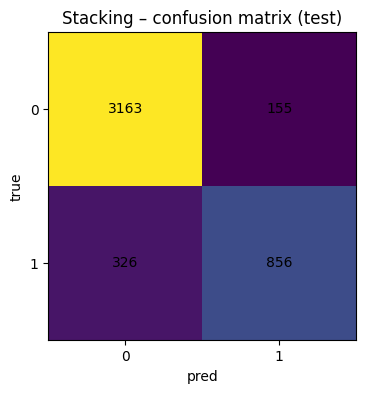

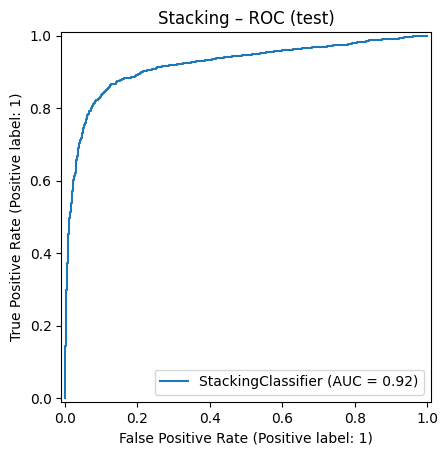

In [23]:
# Диагностика на тесте: confusion matrix и ROC-кривая.

# Confusion matrix помогает понять тип ошибок (FP/FN),
# ROC показывает качество ранжирования вероятностей по всем порогам.

y_pred = best_model.predict(X_test)
plot_confusion(y_test, y_pred, title=f"{best_label} – confusion matrix (test)")
plot_roc(best_model, X_test, y_test, title=f"{best_label} – ROC (test)")

### <font color="blue">📝 Наблюдения</font>
* **Confusion matrix (test)**:

  * True Negative (0→0): 3163
  * False Positive (0→1): 155
  * False Negative (1→0): 326
  * True Positive (1→1): 856

* **Выводы:**

  - Модель корректно классифицирует большинство объектов обоих классов.
  - Ошибки чаще происходят при недообнаружении положительного класса (FN = 326), чем при ложном срабатывании (FP = 155).
  - Для положительного класса F1-score = 0.78, что отражает сбалансированное качество классификации.

* **ROC-кривая (test)**: ROC-AUC = 0.92

* **Выводы:**
  - Модель хорошо различает классы при разных порогах.
  - Высокое значение ROC-AUC говорит о том, что модель почти на 92% случайных пар положительный–отрицательный правильно ранжирует вероятность принадлежности к положительному классу.

## 7. Интерпретация: permutation importance (top‑15)

Permutation importance отвечает на вопрос:

> “Если случайно перемешать один признак, насколько сильно ухудшится качество модели?”

Если качество падает сильно – признак важен. Если почти не меняется – признак малозначим (для этой модели и этой метрики)


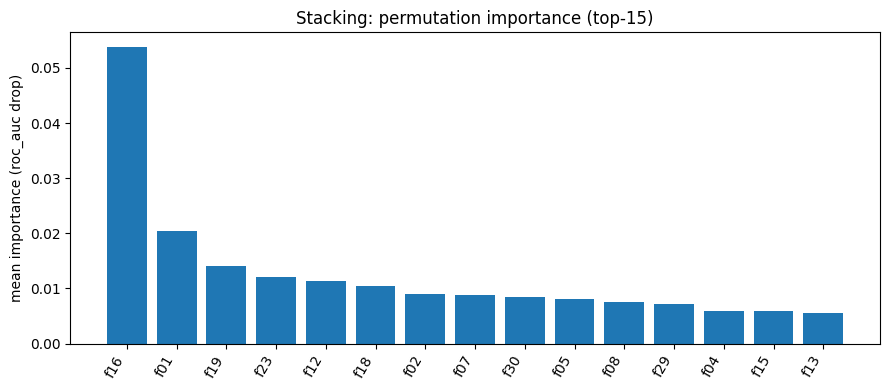

In [26]:
# Permutation importance на тесте (top-15).

# Идея: перемешиваем один признак и смотрим, насколько падает качество.
# Чем больше падение, тем “важнее” признак для модели.

scoring = "roc_auc" if hasattr(best_model, "predict_proba") else "accuracy"

perm = permutation_importance(
    best_model,
    X_test,
    y_test,
    n_repeats=8,
    random_state=RANDOM_STATE,
    scoring=scoring
)

imp = perm.importances_mean
idx = np.argsort(imp)[::-1][:15]

plt.figure(figsize=(9, 4))
plt.bar(range(len(idx)), imp[idx])
plt.xticks(range(len(idx)), [feature_names[i] for i in idx], rotation=60, ha="right")
plt.ylabel(f"mean importance ({scoring} drop)")
plt.title(f"{best_label}: permutation importance (top-15)")
plt.tight_layout()
plt.show()

### <font color="blue">📝 Наблюдения</font>
* **Идея**: перемешиваем значения одного признака и оцениваем падение ROC-AUC; чем больше падение, тем важнее признак.

* **Результаты (топ-15)**: f16, f01, f19, f23, f12, f18, f02, f07, f30, f05, f08, f29, f04, f15, f13.

* f16 имеет наибольшее влияние (~0.05 падение AUC), остальные менее значимы, но всё ещё вносят вклад в качество модели.

**Выводы:**

* Признаки f16, f01 и f19 оказывают ключевое влияние на предсказания модели.
* Анализ подтверждает, что Stacking эффективно использует наиболее информативные признаки и сочетает сильные стороны базовых моделей.

## 8. Сохранение лучшей модели

Сохраним лучшую модель в `artifacts/best_model.joblib`.

Рядом положим `best_model_meta.json` – небольшой файл, где зафиксируем:

- какая именно модель оказалась лучшей;
- её метрики на тесте;
- результаты подбора гиперпараметров (если они были);
- `random_state`, чтобы было проще воспроизвести эксперимент.


In [27]:
# Сохранение лучшей модели и метаданных.

# - best_model.joblib: сериализованная модель
# - best_model_meta.json: “паспорт” результата (какая модель, какие метрики, какие параметры)

model_path = ARTIFACTS_DIR / "best_model.joblib"
joblib.dump(best_model, model_path)

meta = {
    "best_model_label": best_label,
    "test_metrics": best_row.to_dict(),
    "search_summary": search_summaries.get(best_label, None),
    "random_state": RANDOM_STATE,
}
save_json(meta, ARTIFACTS_DIR / "best_model_meta.json")

print("Saved:", model_path)
print("Saved:", ARTIFACTS_DIR / "best_model_meta.json")

Saved: artifacts/best_model.joblib
Saved: artifacts/best_model_meta.json


# <font color="Chocolate">📌 ВЫВОДЫ</font>
1. **Выбор датасета и подготовка данных**

   * Использовали синтетический **S06-hw-dataset-02.csv** для бинарной классификации (`target` 0/1).
   * Датасет содержит 18000 объектов и 37 признаков (без `id` и `target`), пропусков нет, признаки числовые и категориальные с малой мощностью.
   * Целевой класс умеренно несбалансирован: около 26% объектов положительные (target=1).
   * Разбиение на train/test (`0.75/0.25`) с фиксированным `random_state` и стратификацией обеспечило воспроизводимость и сохранение пропорций классов.

2. **Baseline-модели**

   * DummyClassifier (most_frequent) показал минимальное качество (accuracy ≈ 0.737, F1 = 0, ROC-AUC = 0.5), что подтвердило необходимость использования обучаемых моделей.
   * LogisticRegression через Pipeline со StandardScaler показала существенный рост метрик (accuracy ≈ 0.816, F1 ≈ 0.572, ROC-AUC ≈ 0.801), демонстрируя ценность простых линейных моделей с предобработкой признаков.

3. **Модели недели 6**

   * **Decision Tree**: показало умеренное качество (accuracy ≈ 0.819, F1 ≈ 0.619, ROC-AUC ≈ 0.832), при этом подбор `max_depth`, `min_samples_leaf` и `ccp_alpha` позволил контролировать переобучение.
   * **Random Forest**: ансамбль деревьев значительно улучшил показатели (accuracy ≈ 0.868, F1 ≈ 0.686, ROC-AUC ≈ 0.919), демонстрируя снижение дисперсии за счёт bagging и случайного выбора признаков.
   * **HistGradientBoosting**: градиентный бустинг показал сопоставимые результаты (accuracy ≈ 0.866, F1 ≈ 0.697, ROC-AUC ≈ 0.898), выгодно выделяясь на табличных данных.
   * **Stacking (опционально)**: комбинация LogReg + RF + HGB дала наилучшие результаты (accuracy ≈ 0.893, F1 ≈ 0.781, ROC-AUC ≈ 0.920), подтверждая, что разные модели ошибаются по-разному, а метамодель умеет комбинировать их сильные стороны.

4. **Метрики и диагностика**

   * Использование **одних и тех же метрик (accuracy, F1, ROC-AUC)** для всех моделей обеспечило честное сравнение.
   * Confusion matrix и ROC-кривая для лучшей модели Stacking показали высокую способность различать классы.
   * Permutation importance выявила топ-10–15 признаков, которые сильнее всего влияют на прогноз, что позволяет интерпретировать поведение модели и соотнести с логикой данных.

5. **Инженерная часть эксперимента**

   * Все модели, метрики, лучшие параметры и лучшая модель были сохранены в папку `artifacts/`.
   * Использование фиксированного `random_state` и CV на train обеспечило воспроизводимость.
   * Подбор гиперпараметров проводился только на train, test использовался один раз для финальной оценки — корректный ML-протокол.

---

**Вывод:**
* Ансамбли деревьев и градиентный бустинг значительно превосходят простые модели и одиночное дерево.
* Опциональный Stacking ещё улучшил результаты, подтверждая ценность комбинирования разных подходов.
* Эксперимент выполнен в духе «честного ML», с корректной фиксацией разбиений, CV и сохранением артефактов.

